## Discovering the toxicity mechanism of combination therapy by explaining single model prediction

In [1]:
import os

root = '/global/project/hpcg1830/hao/PoSEPath'
os.chdir(root)

In [2]:
from src.eva import *
from src.layers import *

pose = Pose(data_dir, device='cpu')


go-basic.obo: fmt(1.2) rel(2021-05-01) 47,284 GO Terms
  EXISTS: gene2go
HMS:0:00:05.381561 335,858 annotations, 20,671 genes, 18,441 GOs, 1 taxids READ: gene2go 

Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 81% 16,936 of 20,913 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 85% 17,872 of 20,913 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 83% 17,408 of 20,913 population items found in association


### 1. evaluation of model explanations on the training set
#### 1.1 get all the PoSE-pred predictions on the training set and construct the ranked list

In [3]:
query = pose.get_prediction_train()
pred_df = query.get_pred_table()
pred_df = pred_df.sort_values(by='prob', ascending=False)
print(f"{pred_df.shape[0]} predictions in the training set is predicted correctly.")
pred_df.head()


843318 predictions in the training set is predicted correctly.


,drug_1,CID_1,name_1,drug_2,CID_2,name_2,side_effect,side_effect_name,prob,piu,ppiu
841529,209,110635,Tadalafil,159,5212,NA,852,testes pain,0.999998,0.527717,5.96048e-07
841530,218,110634,NA,159,5212,NA,852,testes pain,0.999996,0.526251,-1.1921e-07
841536,218,110634,NA,209,110635,Tadalafil,852,testes pain,0.999992,0.582838,-1.1921e-07
796966,218,110634,NA,209,110635,Tadalafil,708,scotoma,0.999637,0.366919,-5.50947e-05
658266,209,110635,Tadalafil,159,5212,NA,492,elevated prostate specific antigen,0.999422,0.377548,0.000492082


In [11]:
pred_df.to_csv('train_predictions.csv', index=False)

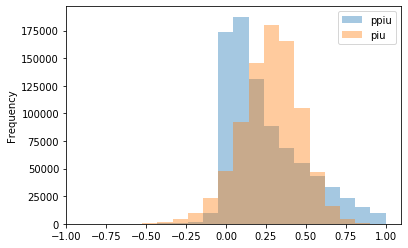

In [4]:
pred_df[['ppiu', 'piu']].plot.hist(bins=20, alpha=0.4)


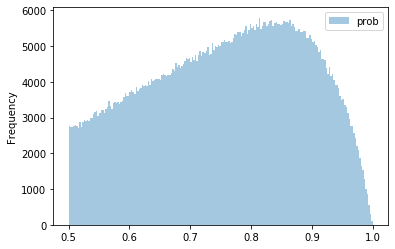

In [5]:
pred_df[['prob']].plot.hist(bins=200, alpha=0.4)

#### 1.2 explain the 200 highest ranked prediction and save results in 'out/exp_single_train/top200'

run pose-path on GPU node: python run_exp_train.py

In [19]:
# the function used to load saved query
def get_single_prediction_query_train(d1, d2, s):
    file_name = f"/out/exp_single_train/top200/{d1}-{d2}-{s}.pkl"
    return PoseQuery.load_from_pkl(root+file_name)

#### 1.3 search biomedical literature evidence for top20 predictions

In [15]:
top20 = pred_df.iloc[:200, :]
top20

,drug_1,CID_1,name_1,drug_2,CID_2,name_2,side_effect,side_effect_name,prob,piu,ppiu
841529,209,110635,Tadalafil,159,5212,NA,852,testes pain,0.999998,0.527717,5.96048e-07
841530,218,110634,NA,159,5212,NA,852,testes pain,0.999996,0.526251,-1.1921e-07
841536,218,110634,NA,209,110635,Tadalafil,852,testes pain,0.999992,0.582838,-1.1921e-07
796966,218,110634,NA,209,110635,Tadalafil,708,scotoma,0.999637,0.366919,-5.50947e-05
658266,209,110635,Tadalafil,159,5212,NA,492,elevated prostate specific antigen,0.999422,0.377548,0.000492082
...,...,...,...,...,...,...,...,...,...,...,...
790426,134,444,bupropion,24,5523,Ultram,693,breast tenderness,0.996536,0.468592,0.00183084
843173,88,4594,omeprazole,15,54454,simvastatin,860,endometriosis,0.996531,0.513731,0.00528626
787786,96,3325,famotidine,31,5039,Ranitidine Base,688,Carcinoma of Prostate,0.996529,0.510322,-0.000135774
834031,215,1983,acetaminophen,84,3883,lansoprazole,820,Meningitis Viral,0.996523,0.205056,0.000281957


In [20]:
top20_query = []
for n in range(200):
    top_n = top20.iloc[n, :].values
    d1, d2, s = top_n[0], top_n[3], top_n[6] 
    top20_query.append(get_single_prediction_query_train(d1, d2, s))

In [21]:
target, ntarget, GOs = [], [], []
j = 0
for q in top20_query:
    j+=1
    ts = set(q.pd_index[0].tolist())
    nts = set(q.pp_index.flatten().tolist())
    gs =  nts | ts

    if len(nts):
        nts = [int(gdata.prot_idx_to_id[i][6:]) for i in gs - ts]
        nts = [gdata.geneid2symbol[i] if gdata.geneid2symbol.get(i) else 'NA' for i in nts]
        ntarget.append(','.join(nts))
    else:
        ntarget.append('NA') 

    if q.if_enrich:
        gos = q.get_GOEnrich_table()['name'].unique().tolist()
        GOs.append(','.join(gos))
    else:
        GOs.append('NA')

    ts = [int(gdata.prot_idx_to_id[i][6:]) for i in ts]
    'sha1:4a79335962a3:da614e7c37cdb6d4f3763cee52d75c3e158e7bfa'
    ts = [gdata.geneid2symbol[i] if gdata.geneid2symbol.get(i) else 'NA' for i in ts]
    target.append(','.join(ts))

    

In [22]:
top20['target'], top20['non-target'], top20['GOs'] = target, ntarget, GOs
top20

        # ts, nts, gs

/global/home/hpc4590/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,drug_1,CID_1,name_1,drug_2,CID_2,name_2,side_effect,side_effect_name,prob,piu,ppiu,target,non-target,GOs
841529,209,110635,Tadalafil,159,5212,NA,852,testes pain,0.999998,0.527717,5.96048e-07,"PDE6B,PDE6C,PDE11A",NA,NA
841530,218,110634,NA,159,5212,NA,852,testes pain,0.999996,0.526251,-1.1921e-07,"PDE6B,PDE10A,PDE5A,PDE6C,ADORA1,PDE11A",NA,NA
841536,218,110634,NA,209,110635,Tadalafil,852,testes pain,0.999992,0.582838,-1.1921e-07,"PDE6B,PDE10A,PDE6C,PDE7A,PDE11A",NA,NA
796966,218,110634,NA,209,110635,Tadalafil,708,scotoma,0.999637,0.366919,-5.50947e-05,"PDE6B,PDE6C,PDE11A",NA,NA
658266,209,110635,Tadalafil,159,5212,NA,492,elevated prostate specific antigen,0.999422,0.377548,0.000492082,"PDE6B,PDE6C,PDE11A",NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790426,134,444,bupropion,24,5523,Ultram,693,breast tenderness,0.996536,0.468592,0.00183084,"OPRM1,OPRK1,SLC6A7,SLC6A13,CYP2C19,SLC6A9,SLC6...",XRCC4,NA
843173,88,4594,omeprazole,15,54454,simvastatin,860,endometriosis,0.996531,0.513731,0.00528626,"HMGCR,ABCB1",UGT1A6,NA
787786,96,3325,famotidine,31,5039,Ranitidine Base,688,Carcinoma of Prostate,0.996529,0.510322,-0.000135774,HRH2,NA,NA
834031,215,1983,acetaminophen,84,3883,lansoprazole,820,Meningitis Viral,0.996523,0.205056,0.000281957,"CREBBP,INS-IGF2,CYP2C19,MIF,PTGS1,LPO,CYP2D6,T...",CHKB,"phosphatidylethanolamine biosynthetic process,..."


In [23]:
top20.to_csv('top200.csv', index=False)

In [30]:
# search on Google scholar with 'search.py'
# load results

gs_results = PoseQuery.load_from_pkl('top20_scholar.pkl')
a, b, c, d, e = [], [], [], [], []
for se, genepub in gs_results.items():
    for t, pub in genepub.items():
        for g, p in pub.items():
            a.append(se)
            b.append(t)
            c.append(g)
            d.append(p[0])
            e.append([get_pub_summary(i) for i in p[1]])


In [32]:
evidence = pandas.DataFrame({'side effect':a, 'if target': b, 'gene': c, '#publication':d, 'evidence':e})
# evi_mac = pandas.DataFrame(PoseQuery.load_from_pkl('tmp.pkl'))

# evidence = pandas.concat((evidence, evi_mac))
# evidence.index = list(range(evidence.shape[0]))

top10 = evidence[evidence['#publication'] > 0][evidence['gene'] != 'NA']


/global/home/hpc4590/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [49]:
with open('top10.pkl', 'wb') as f:
    pickle.dump(top10, f)

### 1.4. exp for sepsis with low prediction score

In [6]:
sepsis_lo = pandas.read_csv('data/sepsis/sepsis_lo.csv')
sepsis_lo


,drug_1,CID_1,name_1,drug_2,CID_2,name_2,side_effect,side_effect_name,prob,piu,ppiu
0,215,1983,acetaminophen,101,2244,aspirin,27,sepsis,0.970549,0.363873,-0.012080
1,215,1983,acetaminophen,89,2662,celecoxib,27,sepsis,0.972884,0.305105,-0.006760
2,215,1983,acetaminophen,113,5029,rabeprazole,27,sepsis,0.969345,0.276162,-0.005292
3,215,1983,acetaminophen,31,5039,Ranitidine Base,27,sepsis,0.953074,0.372629,-0.004106
4,133,5978,vincristine,18,83786,NaN,27,sepsis,0.968776,0.427016,-0.003603
5,215,1983,acetaminophen,116,3385,5-Fluorouracil,27,sepsis,0.980558,0.418709,-0.003381
6,215,1983,acetaminophen,188,4409,nabumetone,27,sepsis,0.954368,0.139491,-0.002807
7,215,1983,acetaminophen,24,5523,Ultram,27,sepsis,0.968413,0.557386,-0.002507
8,188,4409,nabumetone,18,83786,NaN,27,sepsis,0.966213,0.093659,-0.001825
9,215,1983,acetaminophen,22,3937,76547-98-3 (free),27,sepsis,0.962576,0.311532,-0.001379


In [7]:
from src.eva import *

In [9]:
se_lo_exp = load_pred_exp_table('out/sepsis_lo/', sepsis_lo)

In [10]:
se_lo_exp.to_csv('sepsis_lo_exp.csv', index=False)

### 2. evaluation of model explanations on the testing set
We use the same process as on the training set to measure the performance of the testing set. After getting the explanation results for the top, middle and bottom 10 on the ranked list based on AUROC for single predictions.

In [3]:
# load prediction table for testing set
query_test = pose.get_prediction_test()
pred_df_test = query_test.get_pred_table()

In [9]:
pred_df_test.shape[0], pred_df_test.shape[0]/gdata.test_et.shape[0]*2

(93966, 0.7974438617037527)

In [5]:
pred_df_test = pred_df_test.sort_values(by='prob', ascending=False)

In [14]:
top10_test = pred_df_test.iloc[:10, :]

In [15]:
top10_test_exp = load_pred_exp_table('out/exp_single_test/', top10_test)

/global/project/hpcg1830/hao/PoSEPath/src/eva.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top20['target'], top20['non-target'], top20['GOs'] = target, ntarget, GOs


In [17]:
top10_test_exp.to_csv('data/test/top10/top10.csv', index=False)

In [18]:
bot10_test = pred_df_test.iloc[-10:, :]

In [20]:
bot10_test_exp = load_pred_exp_table('out/exp_single_test/', bot10_test)

/global/project/hpcg1830/hao/PoSEPath/src/eva.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top20['target'], top20['non-target'], top20['GOs'] = target, ntarget, GOs


In [21]:
bot10_test_exp.to_csv('data/test/bottom10/bottom10.csv', index=False)